# this demo is setup using python2

In [1]:
# setup envionrmnet
#! python2 -m pip install aliyun-python-sdk-imagesearch

In [2]:
#from IPython.display import Image
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from IPython.display import display
from IPython.core.display import HTML 
import json
from pprint import pprint
import os
import time
#import md5
import hashlib

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: the md5 module is deprecated; use hashlib instead
  # Remove the CWD from sys.path while we load stuff.


In [3]:
def get_md5(txt):
    #return md5.new(txt).digest()
    return hashlib.sha224(txt).hexdigest()

In [4]:
def image_preview(image_path, box, cate):
    #img1 = Image(filename = image_path, width=100, height=100)
    img1 = Image.open(image_path)
    if box is not None and box != '':
        draw = ImageDraw.Draw(img1)
        bb = box.split(",")
        x0 = float(bb[0])
        y0 = float(bb[2])
        x1 = float(bb[1])
        x2 = float(bb[3])
        draw.rectangle([(x0, y0), (x1, x2)], outline='red')
        if cate is not None and cate != "":
            draw.text((x0, y0), cate, fill="red")
    img = img1
    return img

In [5]:
#PATH = "/Users/jianhuashao/code/demo_imagesearch/images_bottle/"
#image_path = PATH + "1.jpg"
#img = image_preview(image_path)
#display(img)

# credential is setup in a seperate ali_config.py 

In [6]:
from aliyunsdkcore import client
from aliyunsdkcore.profile import region_provider

import ali_config

product = "ImageSearch"
region = ali_config.region # via: cn-shanghai(sh), ap-southeast-1(sg)
accessKeyId = ali_config.accessKeyId # via: https://ak-console.aliyun.com
accessKeySecret = ali_config.accessKeySecret
domain = "imagesearch."+ region +".aliyuncs.com"
instanceName = "testforbc";

region_provider.add_endpoint(product, region, domain)
requestClient = client.AcsClient(accessKeyId, accessKeySecret, region)

# function to upload image into alibaba cloud

In [7]:
from aliyunsdkimagesearch.request.v20180120.AddItemRequest import AddItemRequest

def image_upload(instanceName, image_name, image_path):
    # load file
    file_object = open(image_path)
    file_content = None
    try:
        file_content = file_object.read()
    finally:
        file_object.close()
        
    img_id = get_md5(file_content)
    print('img_id: ', img_id)

    request = AddItemRequest()
    request.set_instance_name(instanceName)
    request.set_cate_id("0")
    request.set_item_id(img_id)
    image_content = {'name': image_name, 'path': image_path, 'img_id': img_id}
    request.set_cust_content(json.dumps(image_content))

    print len(file_content)
    request.add_picture(image_name, file_content)
    request.build_post_content()

    result = requestClient.do_action(request)
    return result



In [8]:
# test to upload a single image

#instanceName = "testforbc"; # e.g. imagesearchtest
image_name = '1.jpg'
image_folder = '../images_bottle'
image_path = os.path.abspath(image_folder+'/'+image_name)
result = image_upload(instanceName, image_name, image_path)
print(image_path, result)

('img_id: ', '5c47a64b53c64d8155a4389ec36ed7b0126754cf36d8fe33f0f94abc')
2965
('/Users/jianhuashao/code/demo_imagesearch/images_bottle/1.jpg', '{"Message":"success","RequestId":"ABDD0231-9254-44B8-9EC6-C04B6F1929B3","Success":true,"Code":0}')


In [9]:
# test to upload a list of image

import os
import time
from pprint import pprint

image_folder = os.path.abspath('../images_bottle')
images = {}
for file in os.listdir(image_folder):
    if file.endswith(".jpg"):
        image_path = os.path.join(image_folder, file)
        #print(os.path.abspath(image_path))
        images[image_path] = file

pprint(images)

for image_path in images:
    image_name = images[image_path]
    result = image_upload(instanceName, image_name, image_path)
    print(instanceName, image_name, image_path, result)
    time.sleep(1)

{'/Users/jianhuashao/code/demo_imagesearch/images_bottle/003-220x220.jpg': '003-220x220.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/008-220x220.jpg': '008-220x220.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/1.jpg': '1.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/2.jpg': '2.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/3.jpg': '3.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/4.jpg': '4.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/5.jpg': '5.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/6.jpg': '6.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/7.jpg': '7.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/8.jpg': '8.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/9.jpg': '9.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/IMG_20160507_111836-220x220.jpg': 'IMG_20160507_111836-220x220.jpg',
 '/Users/jianhuashao

# function to search for image in alibaba cloud

In [10]:
from aliyunsdkimagesearch.request.v20180120.SearchItemRequest import SearchItemRequest

def image_search(instanceName, image_path):
    request = SearchItemRequest()

    request.set_instance_name(instanceName)
    request.set_num(20)
    request.set_start(0)

    file_object = open(image_path)
    file_content = None
    try:
        file_content = file_object.read()
    finally:
        file_object.close()

    request.set_search_picture(file_content)

    request.build_post_content()

    result = requestClient.do_action(request)
    return result

In [11]:
def image_search_result(instanceName, image_path):
    result = image_search(instanceName, image_path)
    r = json.loads(result)
    category_desc = ''
    for c in r['PicInfo']['AllCategory']['Category']:
        if r['PicInfo']['Category'] == c['Id']:
            category_desc = c['Name']
    #pprint(r)
    display(image_preview(image_path, r['PicInfo']['Region'], category_desc))
    print(image_path, 'found category_desc: ', category_desc, r['PicInfo']['Category'], 'found category_id: ', r['PicInfo']['Category'], 'found region: ',  r['PicInfo']['Region'])
    return r



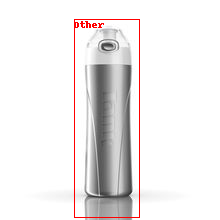

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/1.jpg', 'found category_desc: ', u'Other', u'88888888', 'found category_id: ', u'88888888', 'found region: ', u'74,139,19,217')


In [12]:
# test to search a single image

#instanceName = "testforbc"; # e.g. imagesearchtest
image_name = '1.jpg'
image_folder = '../images_bottle'
image_path = os.path.abspath(image_folder+'/'+image_name)
r = image_search_result(instanceName, image_path)

{'/Users/jianhuashao/code/demo_imagesearch/images_bottle/003-220x220.jpg': '003-220x220.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/008-220x220.jpg': '008-220x220.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/1.jpg': '1.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/2.jpg': '2.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/3.jpg': '3.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/4.jpg': '4.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/5.jpg': '5.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/6.jpg': '6.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/7.jpg': '7.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/8.jpg': '8.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/9.jpg': '9.jpg',
 '/Users/jianhuashao/code/demo_imagesearch/images_bottle/IMG_20160507_111836-220x220.jpg': 'IMG_20160507_111836-220x220.jpg',
 '/Users/jianhuashao

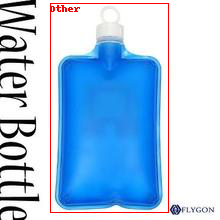

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/7.jpg', 'found category_desc: ', u'Other', u'88888888', 'found category_id: ', u'88888888', 'found region: ', u'50,168,3,212')


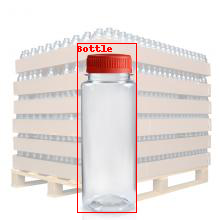

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/5.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'77,136,43,212')


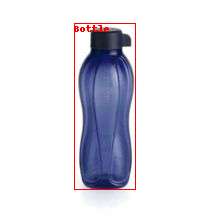

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/3.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'74,135,23,189')


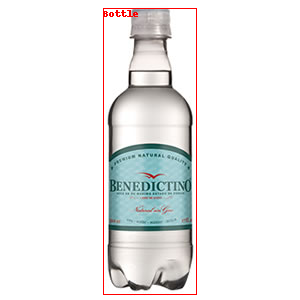

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/4.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'103,196,8,294')


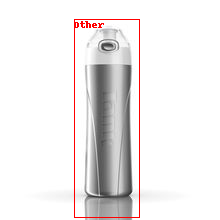

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/1.jpg', 'found category_desc: ', u'Other', u'88888888', 'found category_id: ', u'88888888', 'found region: ', u'74,139,19,217')


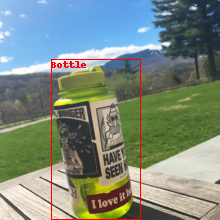

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/WaterBottle11-220x220.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'51,140,59,219')


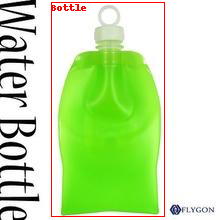

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/6.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'51,164,2,216')


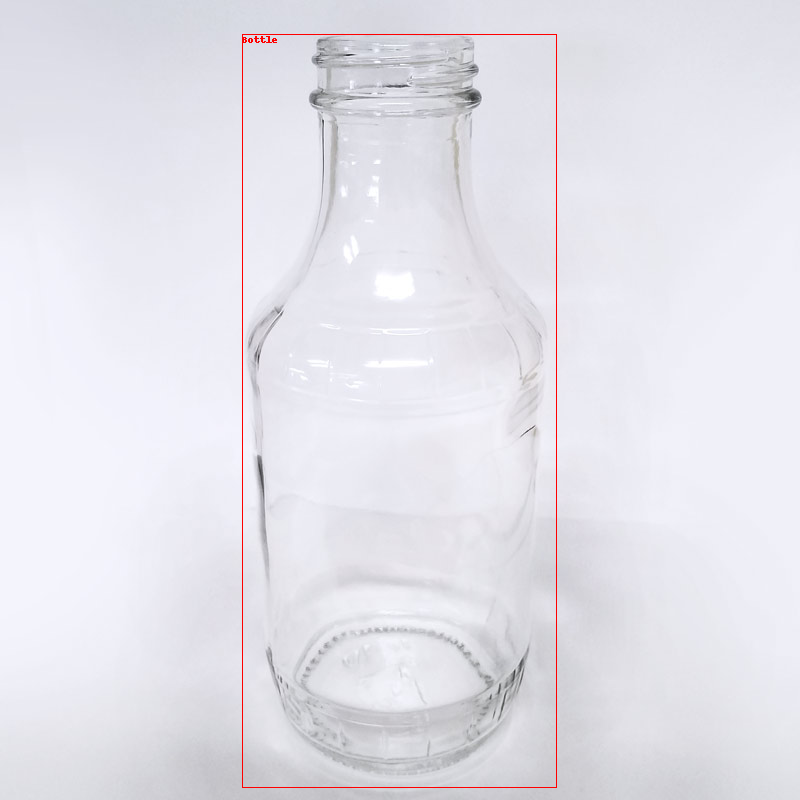

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/bottle-sm-decanter.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'242,556,34,787')


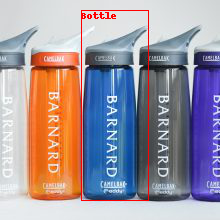

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/003-220x220.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'81,148,10,200')


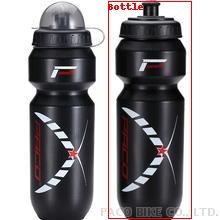

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/9.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'108,191,1,218')


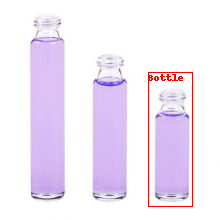

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/prodcat_glass-vials-roller-ball-bottles-220x220.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'148,192,72,206')


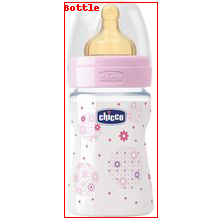

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/2.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'64,157,2,217')


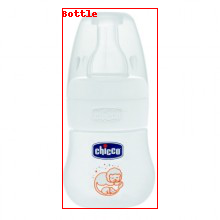

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/008-220x220.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'62,157,8,208')


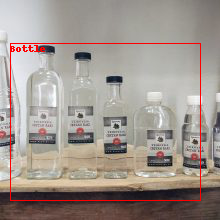

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/IMG_20160507_111836-220x220.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'10,200,43,200')


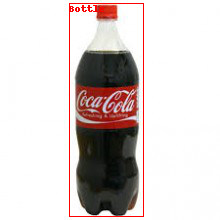

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/downloadcoca-220x220.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'69,143,3,216')


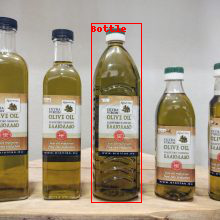

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/IMG_20160507_112417-220x220.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'91,141,23,202')


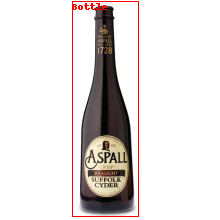

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/8.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'72,138,1,216')


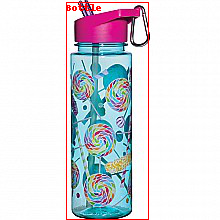

('/Users/jianhuashao/code/demo_imagesearch/images_bottle/tgtgsu1724102.220x220.95b56.jpg', 'found category_desc: ', u'Bottle', u'8', 'found category_id: ', u'8', 'found region: ', u'66,148,2,219')


In [13]:
image_folder = os.path.abspath('../images_bottle')
images = {}
for file in os.listdir(image_folder):
    if file.endswith(".jpg"):
        image_path = os.path.join(image_folder, file)
        #print(os.path.abspath(image_path))
        images[image_path] = file

pprint(images)

for image_path in images:
    image_name = images[image_path]
    r = image_search_result(instanceName, image_path)